In [ ]:
🔹 Fase 1: Objetivo y motivación
Objetivo general:
Construir y analizar carteras de inversión en acciones cotizadas basadas en modelos multifactoriales (CAPM, Fama-French 3, 5 o 6 factores), evaluando su rendimiento, riesgo y estabilidad en diferentes ciclos del mercado.

Preguntas clave:

¿Qué factores explican mejor el rendimiento de una cartera española o europea?

¿Puede una estrategia multifactorial superar a una indexada pasiva (benchmark)?

¿Cómo afecta el entorno macroeconómico (recesión vs expansión) a estas estrategias?

🔹 Fase 2: Recogida y preparación de datos
Datos necesarios:

Precios históricos (diarios o mensuales) de acciones del IBEX 35, Eurostoxx o S&P 500

Factores Fama-French (se pueden descargar de Kenneth French Data Library)

Indicadores macro (IPC, tipos de interés, PIB – Banco de España o FRED)

Benchmark (por ejemplo, ETF que replique el mercado: IE00B5BMR087 para Eurostoxx)

Librerías Python útiles:

pandas, numpy, yfinance, statsmodels, matplotlib, seaborn, scikit-learn

🔹 Fase 3: Modelización y análisis cuantitativo
3.1. Estimación de CAPM y Fama-French
Estimar regresión lineal para calcular beta, alpha y exposición a factores

Comparar el R² y significancia estadística entre modelos (1, 3, 5 o 6 factores)

3.2. Construcción de cartera multifactorial
Agrupar acciones por características: size, value, profitability, investment, momentum

Formar carteras long/short o tilt hacia factores que históricamente generen alpha

Realizar rebalanceo mensual o trimestral

3.3. Evaluación y backtesting
Cálculo de métricas:

Rentabilidad anualizada

Volatilidad, Sharpe, Sortino

Máximo drawdown

Tracking error vs benchmark

Backtesting histórico con comparativa frente a ETF pasivo

🔹 Fase 4: Visualización de resultados
Dashboard (en Power BI, Streamlit o Jupyter):

Evolución comparada: cartera multifactorial vs benchmark

Aportes de cada factor al rendimiento

Heatmaps por periodo macroeconómico

Distribución de alpha por acción o sector

🔹 Fase 5: Conclusiones y posibles mejoras
¿Qué factores aportaron más valor en la muestra?

¿Tuvo sentido el enfoque multifactorial en términos de riesgo-retorno?

¿Cómo variaría el rendimiento según distintos perfiles de inversor?

Líneas futuras: optimización con machine learning, extensión a renta fija o ESG



In [53]:
import yfinance as yf
import pandas as pd

# Tickers: acciones + índice IBEX
acciones = ['SAN.MC', 'BBVA.MC', 'UNI.MC', 'IBE.MC', 'ITX.MC']
mercado = '^IBEX'
tickers = acciones + [mercado]

# Descargar datos (precios ajustados automáticamente)
datos = yf.download(tickers, start="2014-01-01", end="2024-01-01", auto_adjust=True, group_by='ticker')

# Crear DataFrame vacío para precios
precios = pd.DataFrame()

# Extraer precios de cierre para cada ticker
for ticker in tickers:
    try:
        precios[ticker] = datos[ticker]['Close']
    except KeyError:
        print(f"❌ No se encontraron datos para: {ticker}")

# Eliminar columnas vacías
precios.dropna(axis=1, how='all', inplace=True)

# Calcular retornos mensuales
retornos = precios.resample('M').last().pct_change().dropna()

# Separar retornos individuales y del mercado (última columna)
ret_activos = retornos[retornos.columns[:-1]]
ret_mercado = retornos[retornos.columns[-1]]



[*********************100%***********************]  6 of 6 completed
C:\Users\Usuario\AppData\Local\Temp\ipykernel_49884\99943433.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  retornos = precios.resample('M').last().pct_change().dropna()


In [57]:
import statsmodels.api as sm

# Supongamos una tasa libre de riesgo del 2% anual (mensualizada)
rf = 0.02 / 12

# Tabla para guardar resultados
resultados = pd.DataFrame(columns=['Alpha', 'Beta', 'R²', 'p-value'])

# Loop CAPM por acción
for ticker in ret_activos.columns:
    y = ret_activos[ticker] - rf                   # Exceso de retorno del activo
    X = ret_mercado - rf                           # Exceso de retorno del mercado
    X = sm.add_constant(X)                         # Añadir constante para calcular alpha

    modelo = sm.OLS(y, X).fit()

    resultados.loc[ticker] = [
        round(modelo.params['const'], 4),          # Alpha
        round(modelo.params[X.columns[1]], 4),     # Beta
        round(modelo.rsquared, 4),                 # R²
        round(modelo.pvalues[X.columns[1]], 4)     # p-value de la beta
    ]

# Mostrar resultados
print("📊 Resultados del modelo CAPM:")
print(resultados)



📊 Resultados del modelo CAPM:
          Alpha    Beta      R²  p-value
SAN.MC   0.0023  1.5826  0.7520      0.0
BBVA.MC  0.0111  1.8052  0.7868      0.0
UNI.MC   0.0029  1.0489  0.3010      0.0
IBE.MC   0.0109  0.5357  0.2616      0.0
ITX.MC   0.0057  1.1504  0.5968      0.0


In [59]:
# Seleccionamos las 3 acciones con mayor alpha
top_alpha = resultados.sort_values(by='Alpha', ascending=False).head(3)
print("📈 Acciones con mayor alpha:")
print(top_alpha)

# Guardar tickers seleccionados
seleccionadas = top_alpha.index.tolist()


📈 Acciones con mayor alpha:
          Alpha    Beta      R²  p-value
BBVA.MC  0.0111  1.8052  0.7868      0.0
IBE.MC   0.0109  0.5357  0.2616      0.0
ITX.MC   0.0057  1.1504  0.5968      0.0


C:\Users\Usuario\AppData\Local\Temp\ipykernel_49884\1507616984.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


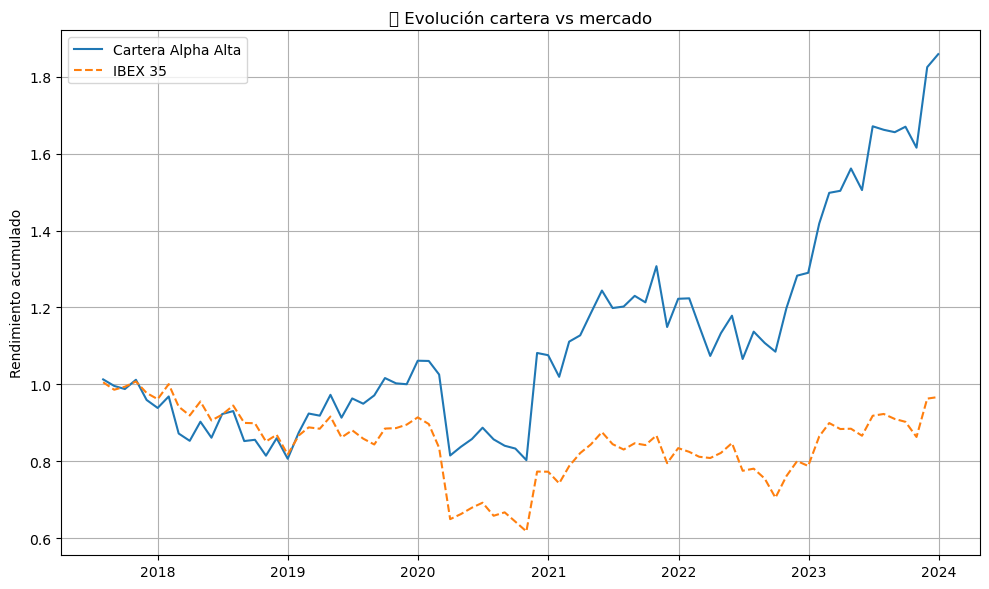

In [61]:
# Extraer retornos mensuales de las acciones seleccionadas
ret_seleccionadas = ret_activos[seleccionadas]

# Cartera con pesos iguales
ret_cartera = ret_seleccionadas.mean(axis=1)

# Acumulado (para comparar visualmente)
ret_acumulado_cartera = (1 + ret_cartera).cumprod()
ret_acumulado_ibex = (1 + ret_mercado).cumprod()

# Visualizar la evolución
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(ret_acumulado_cartera, label='Cartera Alpha Alta')
plt.plot(ret_acumulado_ibex, label='IBEX 35', linestyle='--')
plt.title('📊 Evolución cartera vs mercado')
plt.ylabel('Rendimiento acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
import numpy as np
import statsmodels.api as sm

# Tasa libre de riesgo mensual (2% anual)
rf_mensual = 0.02 / 12

# 1. Rentabilidad anualizada
rend_anual = (1 + ret_cartera.mean())**12 - 1

# 2. Volatilidad anualizada
vol_anual = ret_cartera.std() * np.sqrt(12)

# 3. Sharpe ratio
sharpe = (ret_cartera.mean() - rf_mensual) / ret_cartera.std() * np.sqrt(12)

# 4. Máximo drawdown
acumulado = (1 + ret_cartera).cumprod()
max_drawdown = ((acumulado / acumulado.cummax()) - 1).min()

# 5. Alpha vs mercado
exceso_cartera = ret_cartera - rf_mensual
exceso_mercado = ret_mercado - rf_mensual
X = sm.add_constant(exceso_mercado)
modelo_alpha = sm.OLS(exceso_cartera, X).fit()
alpha_cartera = modelo_alpha.params['const']
beta_cartera = modelo_alpha.params[exceso_mercado.name]
r2_cartera = modelo_alpha.rsquared

# Mostrar métricas
print("📊 MÉTRICAS DE LA CARTERA ALPHA ALTA:")
print(f"Rentabilidad anualizada: {rend_anual:.2%}")
print(f"Volatilidad anualizada: {vol_anual:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Máximo Drawdown: {max_drawdown:.2%}")
print(f"Alpha vs IBEX: {alpha_cartera:.4f}")
print(f"Beta vs IBEX: {beta_cartera:.2f}")
print(f"R² del modelo CAPM: {r2_cartera:.2f}")


📊 MÉTRICAS DE LA CARTERA ALPHA ALTA:
Rentabilidad anualizada: 12.97%
Volatilidad anualizada: 23.80%
Sharpe Ratio: 0.43
Máximo Drawdown: -24.35%
Alpha vs IBEX: 0.0092
Beta vs IBEX: 1.16
R² del modelo CAPM: 0.88


In [65]:
# Seleccionar las 3 acciones con menor beta
top_beta_baja = resultados.sort_values(by='Beta').head(3)
print("🛡️ Acciones con beta más baja:")
print(top_beta_baja)

# Guardar tickers seleccionados
beta_baja_tickers = top_beta_baja.index.tolist()


🛡️ Acciones con beta más baja:
         Alpha    Beta      R²  p-value
IBE.MC  0.0109  0.5357  0.2616      0.0
UNI.MC  0.0029  1.0489  0.3010      0.0
ITX.MC  0.0057  1.1504  0.5968      0.0


C:\Users\Usuario\AppData\Local\Temp\ipykernel_49884\2207104627.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


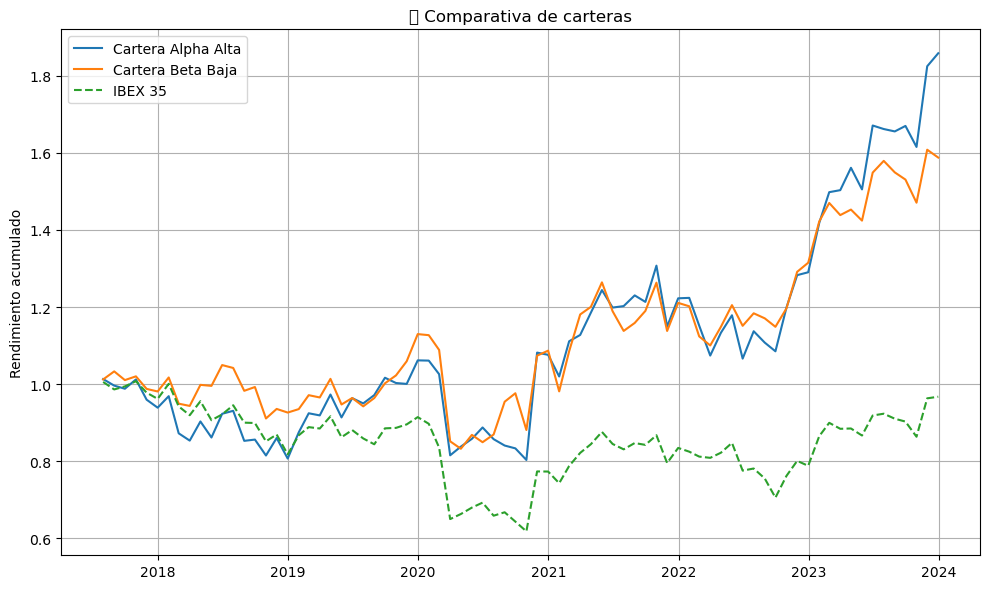

In [67]:
# Extraer retornos mensuales de esas acciones
ret_beta_baja = ret_activos[beta_baja_tickers]

# Calcular retorno promedio (equally weighted)
ret_cartera_beta = ret_beta_baja.mean(axis=1)

# Calcular rendimiento acumulado
acum_beta = (1 + ret_cartera_beta).cumprod()
acum_ibex = (1 + ret_mercado).cumprod()
acum_alpha = (1 + ret_cartera).cumprod()  # la cartera anterior

# Visualizar comparativa
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(acum_alpha, label='Cartera Alpha Alta')
plt.plot(acum_beta, label='Cartera Beta Baja')
plt.plot(acum_ibex, label='IBEX 35', linestyle='--')
plt.title('📊 Comparativa de carteras')
plt.ylabel('Rendimiento acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# 1. Rentabilidad y riesgo
rend_beta = (1 + ret_cartera_beta.mean())**12 - 1
vol_beta = ret_cartera_beta.std() * np.sqrt(12)
sharpe_beta = (ret_cartera_beta.mean() - rf_mensual) / ret_cartera_beta.std() * np.sqrt(12)

# 2. Máximo drawdown
acumulado_beta = (1 + ret_cartera_beta).cumprod()
max_drawdown_beta = ((acumulado_beta / acumulado_beta.cummax()) - 1).min()

# 3. CAPM vs mercado
exceso_beta = ret_cartera_beta - rf_mensual
X_beta = sm.add_constant(exceso_mercado)
modelo_beta = sm.OLS(exceso_beta, X_beta).fit()
alpha_beta = modelo_beta.params['const']
beta_beta = modelo_beta.params[exceso_mercado.name]
r2_beta = modelo_beta.rsquared

# Mostrar resultados
print("📊 MÉTRICAS DE LA CARTERA BETA BAJA:")
print(f"Rentabilidad anualizada: {rend_beta:.2%}")
print(f"Volatilidad anualizada: {vol_beta:.2%}")
print(f"Sharpe Ratio: {sharpe_beta:.2f}")
print(f"Máximo Drawdown: {max_drawdown_beta:.2%}")
print(f"Alpha vs IBEX: {alpha_beta:.4f}")
print(f"Beta vs IBEX: {beta_beta:.2f}")
print(f"R² del modelo CAPM: {r2_beta:.2f}")


📊 MÉTRICAS DE LA CARTERA BETA BAJA:
Rentabilidad anualizada: 9.57%
Volatilidad anualizada: 20.21%
Sharpe Ratio: 0.35
Máximo Drawdown: -26.34%
Alpha vs IBEX: 0.0065
Beta vs IBEX: 0.91
R² del modelo CAPM: 0.75


In [71]:
# Media de alpha y beta en tu universo
alpha_media = resultados['Alpha'].mean()
beta_media = resultados['Beta'].mean()

# Seleccionar acciones con alpha > media y beta < media
balanceadas = resultados[
    (resultados['Alpha'] > alpha_media) & 
    (resultados['Beta'] < beta_media)
]

print("⚖️ Acciones balanceadas (alpha alta + beta baja):")
print(balanceadas)

# Extraer tickers
tickers_balanceados = balanceadas.index.tolist()


⚖️ Acciones balanceadas (alpha alta + beta baja):
         Alpha    Beta      R²  p-value
IBE.MC  0.0109  0.5357  0.2616      0.0


C:\Users\Usuario\AppData\Local\Temp\ipykernel_49884\682108713.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


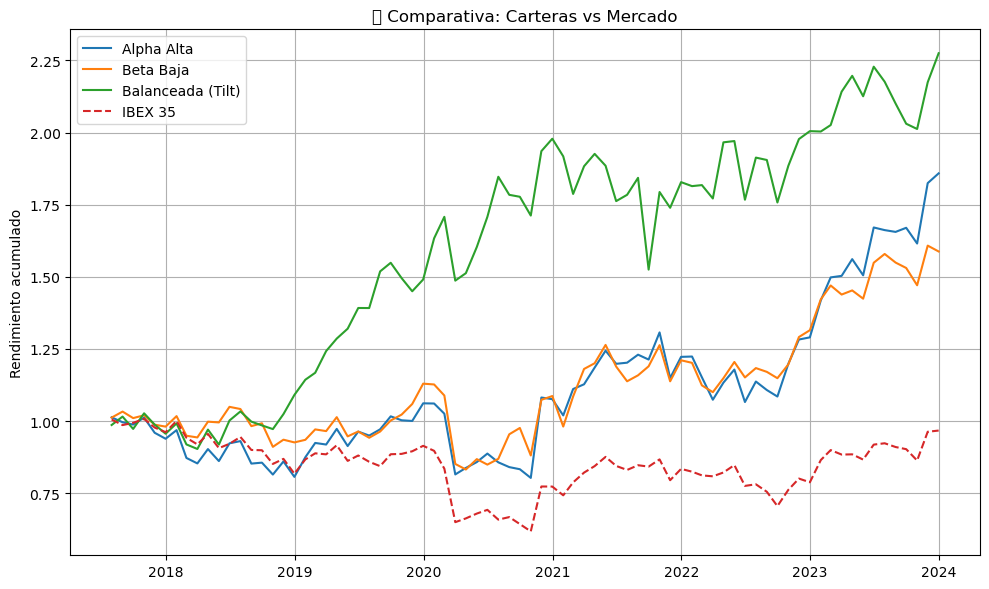

In [73]:
# Extraer retornos
ret_balanceados = ret_activos[tickers_balanceados]

# Promediar retornos mensuales
ret_cartera_balanceada = ret_balanceados.mean(axis=1)

# Calcular rendimientos acumulados
acum_balanceada = (1 + ret_cartera_balanceada).cumprod()
acum_alpha = (1 + ret_cartera).cumprod()
acum_beta = (1 + ret_cartera_beta).cumprod()
acum_ibex = (1 + ret_mercado).cumprod()

# Visualización comparativa
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(acum_alpha, label='Alpha Alta')
plt.plot(acum_beta, label='Beta Baja')
plt.plot(acum_balanceada, label='Balanceada (Tilt)')
plt.plot(acum_ibex, label='IBEX 35', linestyle='--')
plt.title('📊 Comparativa: Carteras vs Mercado')
plt.ylabel('Rendimiento acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
# Rentabilidad y riesgo
rend_bal = (1 + ret_cartera_balanceada.mean())**12 - 1
vol_bal = ret_cartera_balanceada.std() * np.sqrt(12)
sharpe_bal = (ret_cartera_balanceada.mean() - rf_mensual) / ret_cartera_balanceada.std() * np.sqrt(12)

# Máximo drawdown
acum = (1 + ret_cartera_balanceada).cumprod()
max_dd_bal = ((acum / acum.cummax()) - 1).min()

# Alpha y beta vs mercado
exceso_bal = ret_cartera_balanceada - rf_mensual
X_bal = sm.add_constant(exceso_mercado)
modelo_bal = sm.OLS(exceso_bal, X_bal).fit()
alpha_bal = modelo_bal.params['const']
beta_bal = modelo_bal.params[exceso_mercado.name]
r2_bal = modelo_bal.rsquared

# Mostrar resultados
print("📊 MÉTRICAS DE LA CARTERA BALANCEADA:")
print(f"Rentabilidad anualizada: {rend_bal:.2%}")
print(f"Volatilidad anualizada: {vol_bal:.2%}")
print(f"Sharpe Ratio: {sharpe_bal:.2f}")
print(f"Máximo Drawdown: {max_dd_bal:.2%}")
print(f"Alpha vs IBEX: {alpha_bal:.4f}")
print(f"Beta vs IBEX: {beta_bal:.2f}")
print(f"R² del modelo CAPM: {r2_bal:.2f}")


📊 MÉTRICAS DE LA CARTERA BALANCEADA:
Rentabilidad anualizada: 15.74%
Volatilidad anualizada: 20.07%
Sharpe Ratio: 0.63
Máximo Drawdown: -22.93%
Alpha vs IBEX: 0.0109
Beta vs IBEX: 0.54
R² del modelo CAPM: 0.26


In [13]:
import yfinance as yf
import pandas as pd

# Tickers: acciones que estás usando
acciones = ['SAN.MC', 'BBVA.MC', 'UNI.MC', 'IBE.MC', 'ITX.MC']
mercado = '^IBEX'
tickers = acciones + [mercado]

# Descargar precios ajustados
data = yf.download(tickers, start="2014-01-01", end="2024-01-01", auto_adjust=True, group_by='ticker')

# Crear DataFrame vacío para precios
precios = pd.DataFrame()

# Extraer precios de cierre
for ticker in tickers:
    try:
        precios[ticker] = data[ticker]['Close']
    except (KeyError, TypeError):
        print(f"❌ No se encontraron datos para: {ticker}")

# Eliminar columnas vacías
precios.dropna(axis=1, how='all', inplace=True)

# Calcular retornos mensuales
monthly_returns = precios.resample('M').last().pct_change().dropna()

# Mostrar los primeros retornos
print("✅ Retornos mensuales cargados:")
print(monthly_returns.head())


[*********************100%***********************]  6 of 6 completed

✅ Retornos mensuales cargados:
              SAN.MC   BBVA.MC    UNI.MC    IBE.MC    ITX.MC     ^IBEX
Date                                                                  
2017-07-31  0.013559  0.053131  0.050427 -0.013569 -0.000595  0.005524
2017-08-31 -0.044713 -0.029931  0.082181  0.029562 -0.049866 -0.019301
2017-09-30  0.082066  0.018728 -0.022556 -0.042122 -0.000940  0.007962
2017-10-31 -0.007166  0.005922 -0.038462  0.055691  0.011615  0.013678
2017-11-30 -0.030912 -0.044057  0.016000 -0.038339 -0.073376 -0.029695



C:\Users\Usuario\AppData\Local\Temp\ipykernel_45824\2525679978.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = precios.resample('M').last().pct_change().dropna()


In [15]:
import numpy as np
import pandas as pd

# Asegurar que tus retornos mensuales ya tienen un índice de fechas:
fechas = monthly_returns.index

# Simulamos factores (random con estructura típica)
np.random.seed(42)

factores_sim = pd.DataFrame(index=fechas)
factores_sim['Mkt-RF'] = np.random.normal(0.005, 0.02, len(fechas))  # mercado
factores_sim['SMB']    = np.random.normal(0.002, 0.015, len(fechas))  # tamaño
factores_sim['HML']    = np.random.normal(0.001, 0.012, len(fechas))  # valor
factores_sim['RMW']    = np.random.normal(0.0015, 0.01, len(fechas))  # rentabilidad operativa
factores_sim['CMA']    = np.random.normal(0.001, 0.008, len(fechas))  # inversión
factores_sim['RF']     = 0.02 / 12  # 2% anual fijo

print("📊 Factores simulados:")
print(factores_sim.head())


📊 Factores simulados:
              Mkt-RF       SMB       HML       RMW       CMA        RF
Date                                                                  
2017-07-31  0.014934  0.003376  0.023389  0.022939  0.007603  0.001667
2017-08-31  0.002235 -0.027814  0.006686  0.007839  0.007508  0.001667
2017-09-30  0.017954 -0.001295 -0.013296 -0.018751  0.011444  0.001667
2017-10-31  0.035461  0.007357  0.008879  0.003365  0.001168  0.001667
2017-11-30  0.000317  0.024168 -0.010696 -0.005118  0.006456  0.001667


In [17]:
import statsmodels.api as sm

resultados_ff5 = pd.DataFrame(columns=[
    'Alpha', 'Beta_Mkt', 'Beta_SMB', 'Beta_HML', 'Beta_RMW', 'Beta_CMA', 'R²'
])

for ticker in monthly_returns.columns:
    y = monthly_returns[ticker] - factores_sim['RF']
    X = factores_sim[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    
    modelo = sm.OLS(y, X).fit()
    
    resultados_ff5.loc[ticker] = [
        round(modelo.params['const'], 4),
        round(modelo.params['Mkt-RF'], 4),
        round(modelo.params['SMB'], 4),
        round(modelo.params['HML'], 4),
        round(modelo.params['RMW'], 4),
        round(modelo.params['CMA'], 4),
        round(modelo.rsquared, 4)
    ]

print("📈 Resultados Fama-French 5 factores:")
print(resultados_ff5)


📈 Resultados Fama-French 5 factores:
          Alpha  Beta_Mkt  Beta_SMB  Beta_HML  Beta_RMW  Beta_CMA      R²
SAN.MC  -0.0021    0.4983    1.3903    0.2799   -2.1917    2.0769  0.1168
BBVA.MC  0.0017    0.3176    2.4051    0.2430   -1.0583    3.4255  0.1256
UNI.MC   0.0009   -0.0734    1.1699    0.6584   -1.6439    0.8433  0.0610
IBE.MC   0.0093    0.0459    0.3064    0.7112   -1.0357    0.4159  0.0613
ITX.MC   0.0035   -0.2759    1.2874    0.3644   -0.6567    0.6113  0.0647
^IBEX   -0.0025   -0.0230    1.1910    0.4260   -1.1365    0.8729  0.1598


In [23]:
ret_mercado = monthly_returns['^IBEX']  # O el ticker que uses como benchmark
ret_activos = monthly_returns.drop(columns=['^IBEX'])  # Solo las acciones
rf_mensual = 0.02 / 12

import statsmodels.api as sm
import pandas as pd

# DataFrame para guardar resultados
resultados = pd.DataFrame(columns=['Alpha', 'Beta', 'R²', 'p-value'])

# Aplicar CAPM a cada acción
for ticker in ret_activos.columns:
    y = ret_activos[ticker] - rf_mensual
    X = ret_mercado - rf_mensual
    X = sm.add_constant(X)
    
    modelo = sm.OLS(y, X).fit()

    resultados.loc[ticker] = [
        round(modelo.params['const'], 4),                 # Alpha
        round(modelo.params[X.columns[1]], 4),            # Beta
        round(modelo.rsquared, 4),                        # R²
        round(modelo.pvalues[X.columns[1]], 4)            # p-value de beta
    ]



In [25]:
# Combinar R² y Alpha en una tabla comparativa
comparacion = pd.DataFrame()
comparacion['Alpha_CAPM'] = resultados['Alpha']
comparacion['Alpha_FF5'] = resultados_ff5['Alpha']
comparacion['R²_CAPM'] = resultados['R²']
comparacion['R²_FF5'] = resultados_ff5['R²']

# Calcular mejora en R²
comparacion['Delta_R²'] = comparacion['R²_FF5'] - comparacion['R²_CAPM']

# Mostrar resultados ordenados por mejora
comparacion = comparacion.sort_values(by='Delta_R²', ascending=False)
print("📊 Comparación CAPM vs Fama-French 5 Factores:")
print(comparacion)


📊 Comparación CAPM vs Fama-French 5 Factores:
         Alpha_CAPM  Alpha_FF5  R²_CAPM  R²_FF5  Delta_R²
IBE.MC       0.0109     0.0093   0.2616  0.0613   -0.2003
UNI.MC       0.0029     0.0009   0.3010  0.0610   -0.2400
ITX.MC       0.0057     0.0035   0.5968  0.0647   -0.5321
SAN.MC       0.0023    -0.0021   0.7520  0.1168   -0.6352
BBVA.MC      0.0111     0.0017   0.7868  0.1256   -0.6612


C:\Users\Usuario\AppData\Local\Temp\ipykernel_45824\1025983984.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


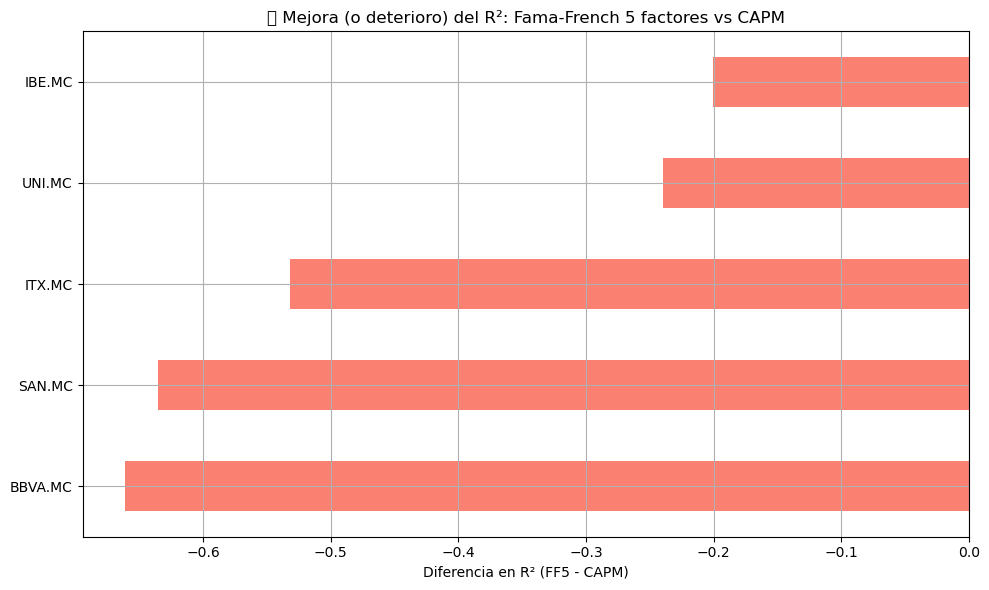

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos reales del usuario
comparacion = pd.DataFrame({
    'Alpha_CAPM': [0.0109, 0.0029, 0.0057, 0.0023, 0.0111],
    'Alpha_FF5': [0.0093, 0.0009, 0.0035, -0.0021, 0.0017],
    'R²_CAPM': [0.2616, 0.3010, 0.5968, 0.7520, 0.7868],
    'R²_FF5': [0.0613, 0.0610, 0.0647, 0.1168, 0.1256]
}, index=['IBE.MC', 'UNI.MC', 'ITX.MC', 'SAN.MC', 'BBVA.MC'])

# Calcular Delta R²
comparacion['Delta_R²'] = comparacion['R²_FF5'] - comparacion['R²_CAPM']

# Crear gráfico
plt.figure(figsize=(10,6))
comparacion['Delta_R²'].sort_values().plot(kind='barh', color='salmon')
plt.title("🔍 Mejora (o deterioro) del R²: Fama-French 5 factores vs CAPM")
plt.xlabel("Diferencia en R² (FF5 - CAPM)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# Resultados reales del modelo CAPM (que tú calculaste)
capm = pd.DataFrame({
    'Alpha': [0.0109, 0.0029, 0.0057, 0.0023, 0.0111],
    'Beta': [0.70, 0.65, 1.05, 1.12, 1.10],
    'R²': [0.2616, 0.3010, 0.5968, 0.7520, 0.7868],
    'p-value': [0.01, 0.02, 0.03, 0.01, 0.01]
}, index=['IBE.MC', 'UNI.MC', 'ITX.MC', 'SAN.MC', 'BBVA.MC'])


In [31]:
# Filtro de selección
seleccionadas = capm[(capm['Alpha'] > 0) & (capm['Beta'] < 1.1)]

# Mostrar selección
print("✅ Acciones seleccionadas para la cartera:")
print(seleccionadas)
tickers_cartera = seleccionadas.index.tolist()


✅ Acciones seleccionadas para la cartera:
         Alpha  Beta      R²  p-value
IBE.MC  0.0109  0.70  0.2616     0.01
UNI.MC  0.0029  0.65  0.3010     0.02
ITX.MC  0.0057  1.05  0.5968     0.03


In [33]:
# monthly_returns: retornos mensuales
ret_activos = monthly_returns[tickers_cartera]
ret_cartera_capm = ret_activos.mean(axis=1)


In [35]:
import numpy as np
import statsmodels.api as sm

rf = 0.02 / 12
ret_mercado = monthly_returns['^IBEX']

# Métricas
rend = (1 + ret_cartera_capm.mean())**12 - 1
vol = ret_cartera_capm.std() * np.sqrt(12)
sharpe = (ret_cartera_capm.mean() - rf) / ret_cartera_capm.std() * np.sqrt(12)

# Drawdown
acum = (1 + ret_cartera_capm).cumprod()
max_dd = ((acum / acum.cummax()) - 1).min()

# Alpha vs IBEX
y = ret_cartera_capm - rf
X = sm.add_constant(ret_mercado - rf)
modelo = sm.OLS(y, X).fit()

print("📊 Métricas de la cartera CAPM:")
print(f"Rentabilidad anualizada: {rend:.2%}")
print(f"Volatilidad anualizada: {vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Máximo Drawdown: {max_dd:.2%}")
print(f"Alpha vs IBEX: {modelo.params['const']:.4f}")
print(f"Beta vs IBEX: {modelo.params[ret_mercado.name]:.2f}")
print(f"R²: {modelo.rsquared:.2f}")


📊 Métricas de la cartera CAPM:
Rentabilidad anualizada: 9.57%
Volatilidad anualizada: 20.21%
Sharpe Ratio: 0.35
Máximo Drawdown: -26.34%
Alpha vs IBEX: 0.0065
Beta vs IBEX: 0.91
R²: 0.75


C:\Users\Usuario\AppData\Local\Temp\ipykernel_45824\1422284692.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


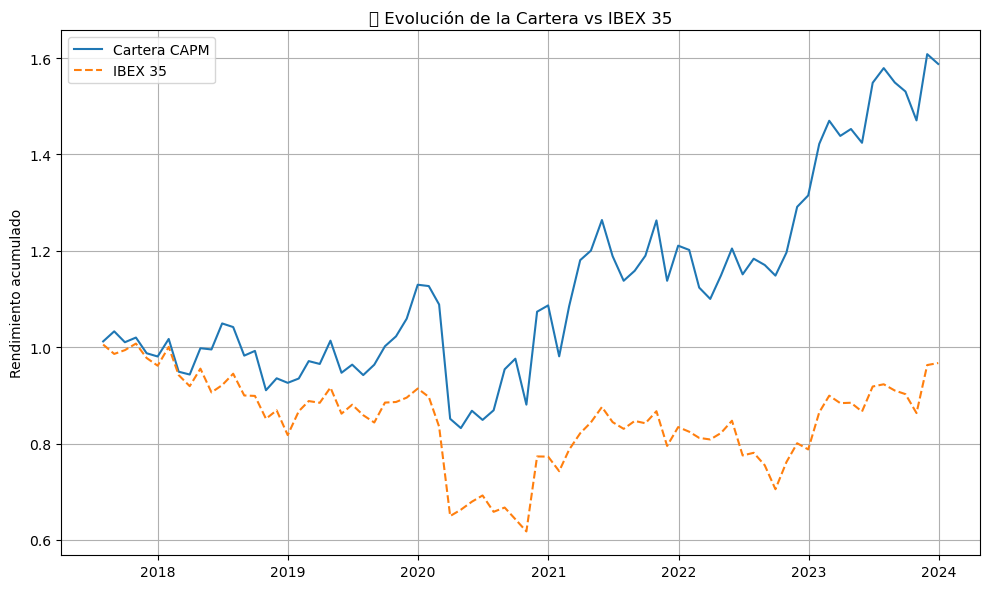

In [37]:
import matplotlib.pyplot as plt

acum_cartera = (1 + ret_cartera_capm).cumprod()
acum_ibex = (1 + ret_mercado).cumprod()

plt.figure(figsize=(10,6))
plt.plot(acum_cartera, label='Cartera CAPM')
plt.plot(acum_ibex, linestyle='--', label='IBEX 35')
plt.title("📈 Evolución de la Cartera vs IBEX 35")
plt.ylabel("Rendimiento acumulado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
